In [8]:
import pickle
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input, Activation, Dense, Permute, Dropout
from tensorflow.keras.layers import add, dot, concatenate
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop

import math
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

import matplotlib.pyplot as plt
%matplotlib inline


In [9]:
with open("/content/train_qa.txt", "rb") as fp:   # Unpickling, read-binary
    train_data =  pickle.load(fp)

with open("/content/test_qa.txt", "rb") as fp:   # Unpickling
    test_data =  pickle.load(fp)

In [5]:
type(train_data), type(test_data)

(list, list)

In [12]:
len(train_data), len(test_data)

(10000, 1000)

In [11]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [13]:
test_data[0]

(['Mary',
  'got',
  'the',
  'milk',
  'there',
  '.',
  'John',
  'moved',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'John', 'in', 'the', 'kitchen', '?'],
 'no')

In [14]:
text=''
print('Story:')
for sent in train_data[99]:
    if sent!='yes' and sent!='no':
        for word in sent:
            if (word!='.'):
                if (word!='?'):
                    text+= word + ' '
                else:
                    print()
                    print('Question:', text[:-1]+word)
                    print()
            else:
                print(text[:-1]+word)
                text=''
    else:
        print('Answer:', sent)

Story:
Daniel grabbed the apple there.
Daniel went to the bedroom.
John moved to the garden.
Sandra journeyed to the office.
Daniel put down the apple.
Mary went to the bedroom.
Mary grabbed the apple there.
Sandra went back to the garden.
Mary went to the kitchen.
Daniel went to the office.

Question: Is Mary in the garden?

Answer: no


In [15]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [16]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [17]:
train_data[0][2]

'no'

In [18]:
vocab = set()
all_data = test_data + train_data
len(all_data)

11000

In [19]:
set(train_data[0][0])

{'.',
 'Mary',
 'Sandra',
 'bathroom',
 'bedroom',
 'journeyed',
 'moved',
 'the',
 'to'}

In [20]:
for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))


In [21]:
vocab.add('no')
vocab.add('yes')

In [22]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [23]:
vocab_len = len(vocab) + 1
vocab_len

38

In [24]:
max_story_len = max([len(data[0]) for data in all_data])
max_story_len

156

In [25]:
max_question_len = max([len(data[1]) for data in all_data])
max_question_len

6

In [26]:
vocab_size = len(vocab) + 1

In [27]:
tokenizer = Tokenizer(filters=[])   # provide empty list for filter out
tokenizer.fit_on_texts(vocab)

In [28]:
tokenizer.word_index

{'yes': 1,
 'travelled': 2,
 'to': 3,
 'there': 4,
 'in': 5,
 'is': 6,
 'down': 7,
 'bathroom': 8,
 'sandra': 9,
 '.': 10,
 'discarded': 11,
 'back': 12,
 'put': 13,
 'football': 14,
 'john': 15,
 'took': 16,
 'apple': 17,
 'milk': 18,
 'got': 19,
 'garden': 20,
 'mary': 21,
 'picked': 22,
 'up': 23,
 'hallway': 24,
 'office': 25,
 'kitchen': 26,
 'daniel': 27,
 'went': 28,
 '?': 29,
 'grabbed': 30,
 'no': 31,
 'journeyed': 32,
 'left': 33,
 'moved': 34,
 'bedroom': 35,
 'the': 36,
 'dropped': 37}

In [29]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [30]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [31]:
len(train_story_text), len(train_story_seq)

(10000, 10000)

In [32]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):


    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []


    for story, query, answer in data:

        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]

        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(vocab_size)  # this includes +1 for padding

        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        y[word_index[answer]] = 1

        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)

    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.

    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [33]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [34]:
inputs_test

array([[ 0,  0,  0, ..., 36, 35, 10],
       [ 0,  0,  0, ..., 36, 20, 10],
       [ 0,  0,  0, ..., 36, 20, 10],
       ...,
       [ 0,  0,  0, ..., 36, 17, 10],
       [ 0,  0,  0, ..., 36, 20, 10],
       [ 0,  0,  0, ..., 17,  4, 10]], dtype=int32)

In [35]:
queries_test

array([[ 6, 15,  5, 36, 26, 29],
       [ 6, 15,  5, 36, 26, 29],
       [ 6, 15,  5, 36, 20, 29],
       ...,
       [ 6, 21,  5, 36, 35, 29],
       [ 6,  9,  5, 36, 20, 29],
       [ 6, 21,  5, 36, 20, 29]], dtype=int32)

In [36]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [37]:
sum(answers_test)

array([  0., 497.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 503.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [38]:
tokenizer.word_index['yes']

1

In [39]:
tokenizer.word_index['no']

31

In [40]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [41]:
embedding_dim = 128

# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim= embedding_dim))
input_encoder_m.add(Dropout(0.3))

In [42]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [43]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embedding_dim,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [44]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [45]:
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [46]:
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [48]:
answer = concatenate([response, question_encoded])
answer

<KerasTensor: shape=(None, 6, 284) dtype=float32 (created by layer 'concatenate_1')>

In [49]:
answer = LSTM(32)(answer)

In [50]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [51]:
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 156)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 128)            4864      ['input_1[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 6, 128)               4864      ['input_2[0][0]']             
                                                                                              

In [53]:
initial_learning_rate = 0.01
epochs = 150
decay = initial_learning_rate / epochs

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 20
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

learning_rate = LearningRateScheduler(lr_step_decay, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.66, patience=5, min_lr=0.0001, verbose=1)  # factor by which the learning rate will be reduced. new_lr = lr * factor

In [55]:
trained_model = model.fit([inputs_train, queries_train], answers_train,batch_size=256,epochs=150,validation_data=([inputs_test, queries_test], answers_test))  # , callbacks=[reduce_lr]

Epoch 1/150
40/40 [==============================] - 5s 114ms/step - loss: 0.7043 - accuracy: 0.4986 - val_loss: 0.8185 - val_accuracy: 0.4970
Epoch 2/150
40/40 [==============================] - 4s 98ms/step - loss: 0.7051 - accuracy: 0.4955 - val_loss: 0.7649 - val_accuracy: 0.4970
Epoch 3/150
40/40 [==============================] - 4s 101ms/step - loss: 0.7046 - accuracy: 0.4991 - val_loss: 0.7366 - val_accuracy: 0.4970
Epoch 4/150
40/40 [==============================] - 5s 123ms/step - loss: 0.7056 - accuracy: 0.4983 - val_loss: 0.7324 - val_accuracy: 0.4970
Epoch 5/150
40/40 [==============================] - 4s 97ms/step - loss: 0.7020 - accuracy: 0.4995 - val_loss: 0.6957 - val_accuracy: 0.4970
Epoch 6/150
40/40 [==============================] - 4s 95ms/step - loss: 0.7014 - accuracy: 0.5017 - val_loss: 0.7114 - val_accuracy: 0.4970
Epoch 7/150
40/40 [==============================] - 5s 131ms/step - loss: 0.7029 - accuracy: 0.4983 - val_loss: 0.7017 - val_accuracy: 0.5030
Ep

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


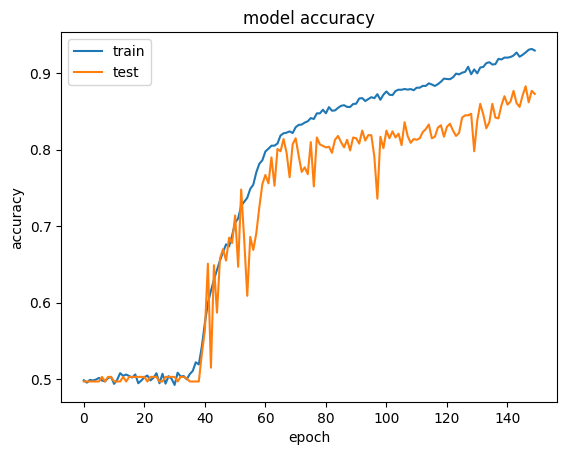

In [58]:
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('accuracy.png', dpi=180, facecolor='white')
plt.show()

In [50]:
pred_results = model.predict(([inputs_test, queries_test]))


32/32 [==============================] - 1s 5ms/step


In [51]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [52]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [53]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [54]:
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.99999374


In [60]:
# Testing the model using own story

my_story = " Mary took the apple . Mary went to the hallway . John picked up the football . Daniel went to the garden ."
my_question = "Is apple in the garden ?"
mydata = [(my_story.split(),my_question.split(),'no')]
my_story,my_ques,my_ans = vectorize_stories(mydata)

pred_results = model.predict(([ my_story, my_ques]))

1/1 [==============================] - 0s 493ms/step


In [61]:
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.71181506
